In [1]:
from PIL import Image
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm

# Use IoU instead
# import re
from scipy.spatial.distance import cdist
from skimage.transform import resize

D:\zsh\graduation\grad_env_take_2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# path of the image folders for the model
image_path_cityscapes = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\original_cityscapes_inputs"
image_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\image"

# path of image folders for displaying in the system

start = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image"
relative_img_path_cityscapes = os.path.relpath(image_path_cityscapes, start)
relative_img_path_synthia = os.path.relpath(image_path_synthia, start)

In [8]:
pickle_file = os.path.join("D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\5_classes_preprocessed", "validation_label_classes.pkl")
with open(pickle_file, 'rb') as f:
    Y_test = pickle.load(f)
    
cityscapes_labels = np.array(Y_test)

In [5]:
sample_number = 10

In [6]:
cityscapes_names= os.listdir(image_path_cityscapes)
random.seed(55)
cityscapes_names_sample = random.sample(cityscapes_names,sample_number)

In [11]:
cityscapes_labels_sample= []
cityscapes_label_path_sample = []

for name in cityscapes_names_sample:
    ind = int(name.split('.')[0]) # todo: change this for other names
    label = cityscapes_labels[ind]
    
    cityscapes_labels_sample.append(label)

cityscapes_labels_sample = np.array(cityscapes_labels_sample)



Cityscapes

In [12]:
class CityscapesDataset(Dataset):
    
    def __init__(self, images, labels, noise_level = 0):
        self.images = images
        self.labels = labels
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.noise_level!=0:
            image = image+(self.noise_level*np.random.normal(0, (image.max() - image.min()), image.shape)).astype("uint8") # (mean, sigma, image_shape)
        image = self.transform(image)
        label = torch.from_numpy(label).long()
        return image, label
        
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # normalize to control the "dynamic range" of activations of different layers
        ])
        return transform_ops(image)

In [13]:
cityscapes_images= []
for name in cityscapes_names_sample:
    image = Image.open(image_path_cityscapes+"\\"+name).convert("RGB")
    cityscapes_images.append(image)

In [15]:
batch_size = 1
cityscapes_dataset = CityscapesDataset(cityscapes_images, cityscapes_labels,noise_level=0)
cityscapes_loader = DataLoader(cityscapes_dataset, batch_size=batch_size)

In [16]:
len(cityscapes_loader)

10

In [17]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [21]:
model_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\5-classes-U-Net-2023-03-09.pth"

device = torch.device('cpu')
model_ = UNet(num_classes=6).to(device)
model_.load_state_dict(torch.load(model_path,map_location=device))

<All keys matched successfully>

In [27]:
print(len(model_.middle))

6


In [14]:
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cityscapes_activations = []

for image,label in tqdm(cityscapes_loader):
    activation = {}
    h = model_.middle[5].register_forward_hook(getActivation("bottleneck"))
    out = model_(image)
    h.remove()
    instance_activation = activation["bottleneck"]
    instance_activation_reshaped = instance_activation.clone().squeeze(0).reshape(256,1024).numpy()
    cityscapes_activations.append(instance_activation_reshaped)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


IndexError: list index out of range

In [21]:
cityscapes_activations_moddle_5=cityscapes_activations.copy()

In [39]:
cityscapes_activations_moddle_5 = np.array(cityscapes_activations_moddle_5)

In [28]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out, middle_out

In [29]:
model_ = UNet(num_classes=6).to(device)
model_.load_state_dict(torch.load(model_path,map_location=device))

<All keys matched successfully>

output size [1,6,256,256]

activations size[1,1024,16,16]

In [30]:
# change the activations first
cityscapes_activations = []

for image,label in tqdm(cityscapes_loader):
    output,activations = model_(image)
    instance_activation_reshaped = activations.clone().squeeze(0).reshape(256,1024).detach().numpy()
    cityscapes_activations.append(instance_activation_reshaped)

 ... (more hidden) ...


In [31]:
cityscapes_activations_correct = np.array(cityscapes_activations)

In [32]:
cityscapes_activations_correct.shape

(10, 256, 1024)

In [40]:
print(cityscapes_activations_correct.shape)
print(cityscapes_activations_moddle_5.shape)

(10, 256, 1024)
(10, 256, 1024)


In [41]:
cityscapes_activations_correct[0]

array([[-9.6487328e-03, -9.6487328e-03, -9.6487328e-03, ...,
         1.8445213e+00, -7.2949678e-02, -7.2949678e-02],
       [-4.8238605e-01, -4.8238605e-01, -4.8238605e-01, ...,
         7.4306473e-02,  7.4306473e-02,  7.4306473e-02],
       [-3.1865224e-01, -3.1865224e-01,  1.3132114e+01, ...,
        -1.7004824e-01, -1.7004824e-01, -1.7004824e-01],
       ...,
       [ 4.9915761e-03,  4.9915761e-03,  4.9915761e-03, ...,
        -6.7413487e-02, -6.7413487e-02, -6.7413487e-02],
       [-2.7201825e-01, -2.7201825e-01, -2.7201825e-01, ...,
        -3.1879300e-01, -3.1879300e-01, -3.1879300e-01],
       [-1.2684970e-01, -1.2684970e-01, -1.2684970e-01, ...,
        -7.2249420e-02, -7.2249420e-02, -7.2249420e-02]], dtype=float32)

In [42]:
cityscapes_activations_moddle_5[0]

array([[-9.6487328e-03, -9.6487328e-03, -9.6487328e-03, ...,
         1.8445213e+00, -7.2949678e-02, -7.2949678e-02],
       [-4.8238605e-01, -4.8238605e-01, -4.8238605e-01, ...,
         7.4306473e-02,  7.4306473e-02,  7.4306473e-02],
       [-3.1865224e-01, -3.1865224e-01,  1.3132114e+01, ...,
        -1.7004824e-01, -1.7004824e-01, -1.7004824e-01],
       ...,
       [ 4.9915761e-03,  4.9915761e-03,  4.9915761e-03, ...,
        -6.7413487e-02, -6.7413487e-02, -6.7413487e-02],
       [-2.7201825e-01, -2.7201825e-01, -2.7201825e-01, ...,
        -3.1879300e-01, -3.1879300e-01, -3.1879300e-01],
       [-1.2684970e-01, -1.2684970e-01, -1.2684970e-01, ...,
        -7.2249420e-02, -7.2249420e-02, -7.2249420e-02]], dtype=float32)

# Continue with the correct form

In [34]:
cityscapes_activations_correct.shape

(10, 256, 1024)

In [35]:
# find the min and max value of this 3d array
min_value = np.min(cityscapes_activations_correct)
max_value = np.max(cityscapes_activations_correct)
print("Min Value: ", min_value)
print("Max Value: ", max_value)


Min Value:  -21.021078
Max Value:  117.311035


<AxesSubplot:ylabel='Count'>

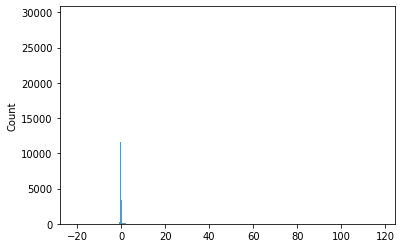

In [38]:
# Flatten the cityscapes_activations_correct from 3D to 1D
flattened_activations = cityscapes_activations_correct.flatten()

# Plot the distribution of the values in a histogram format in seaborn
sns.histplot(flattened_activations)


array([[[-9.64873284e-03, -9.64873284e-03, -9.64873284e-03, ...,
          1.84452128e+00, -7.29496777e-02, -7.29496777e-02],
        [-4.82386053e-01, -4.82386053e-01, -4.82386053e-01, ...,
          7.43064731e-02,  7.43064731e-02,  7.43064731e-02],
        [-3.18652242e-01, -3.18652242e-01,  1.31321144e+01, ...,
         -1.70048237e-01, -1.70048237e-01, -1.70048237e-01],
        ...,
        [ 4.99157608e-03,  4.99157608e-03,  4.99157608e-03, ...,
         -6.74134865e-02, -6.74134865e-02, -6.74134865e-02],
        [-2.72018254e-01, -2.72018254e-01, -2.72018254e-01, ...,
         -3.18792999e-01, -3.18792999e-01, -3.18792999e-01],
        [-1.26849696e-01, -1.26849696e-01, -1.26849696e-01, ...,
         -7.22494200e-02, -7.22494200e-02, -7.22494200e-02]],

       [[-4.03089598e-02, -4.03089598e-02, -4.03089598e-02, ...,
         -1.55643225e-01, -1.55643225e-01, -1.55643225e-01],
        [-5.21776974e-01, -5.21776974e-01, -5.21776974e-01, ...,
         -1.77105516e-03, -1.77105516e

# Check the model activations

In [41]:
# load noise activations
with open('D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter\\activations_2d-noise-0-1-5_middle_5.pkl', 'rb') as f:
    noise_activations_original = pickle.load(f)

In [42]:
noise_activations_original.shape

(153600, 1024)

In [48]:
noise_levels = [0,1,2,3,4,5]

In [43]:
def normalize_3d_array(array_3d):
    array_min = np.min(array_3d)
    array_max = np.max(array_3d)
    normalized_array = (array_3d - array_min) / (array_max - array_min)
    return normalized_array

In [44]:
noise_activations_normalized = normalize_3d_array(noise_activations_original)

In [45]:
tsne = TSNE()
activations_tsne_embedding_new = TSNE(n_components=2).fit_transform(noise_activations_normalized)

In [46]:
with open('normalized_activation_tsne_embedding_0_1_5.pkl', 'wb') as f:
    pickle.dump(activations_tsne_embedding_new, f)

In [51]:
activations_tsne_embedding_new.shape

(153600, 2)

In [52]:
activations_tsne_embedding_reshaped = np.reshape(activations_tsne_embedding_new,(len(noise_levels)*100,256,2))

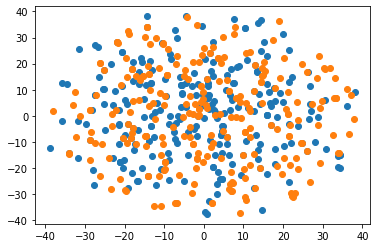

In [54]:
plt.scatter(activations_tsne_embedding_reshaped[0,:,0],activations_tsne_embedding_reshaped[0,:,1])
plt.scatter(activations_tsne_embedding_reshaped[500,:,0],activations_tsne_embedding_reshaped[500,:,1])

经验:
1. 10个照片应该就够用了，能看大概的效果
2. pca测起来最快
3. 看看能不能直接把activation-prediction link 加在这里

# Try other appoaches
1. range cutoff ("clipping")
2. yeon-johnson (power cut-off)
3. RobustScaler in scikit-learn
    This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
4.

In [ ]:
# also check for PCA